# **Spring 2025 Research Project - Transformer-Based Autism Diagnosis Prediction Using AQ10 Scores and Demographic Data**

### **Problem statement**: How can Transformer-based models be utilized to identify and analyze age-related patterns in AQ10 questionnaire responses to enhance the understanding of autism spectrum disorder (ASD) traits across different developmental stages?

### **Direction of visualization/application**:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Run this cell to download the dataset to notebook directory
from pathlib import Path
DATA_ROOT=Path("/content/drive/MyDrive/Projects/Spring-2025-Research/dataset")
!kaggle datasets download -d andrewmvd/autism-screening-on-adults -p {DATA_ROOT}
!unzip { DATA_ROOT / Path('autism-screening-on-adults.zip') } -d {DATA_ROOT}

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/autism-screening-on-adults
License(s): other
autism-screening-on-adults.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/drive/MyDrive/Projects/Spring-2025-Research/dataset/autism-screening-on-adults.zip
  inflating: /content/drive/MyDrive/Projects/Spring-2025-Research/dataset/autism_screening.csv  


In [23]:
from pathlib import Path

class Config:
    # Data configuration
    RAW_DATA_PATH = Path("/content/drive/MyDrive/Projects/Spring-2025-Research/dataset/autism_screening.csv")
    PROCESSED_DATA_DIR = Path("/content/drive/MyDrive/Projects/Spring-2025-Research/dataset/processed")
    CHECKPOINT_DIR = Path("/content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints")
    MODEL_DIR = Path("/content/drive/MyDrive/Projects/Spring-2025-Research/models")

    # Model hyperparameters
    MODEL_DIM = 64
    NUM_LAYERS = 4
    DROPOUT = 0.2
    LEARNING_RATE = 1e-3
    BATCH_SIZE = 64
    EPOCHS = 20

    # Data processing
    FEATURE_LEN = 13  # AQ10 scores + age + gender + result

    @classmethod
    def setup_directories(cls):
        cls.PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)
        cls.CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
        cls.MODEL_DIR.mkdir(parents=True, exist_ok=True)

## Data Preprocessing

In [3]:
import polars as pl
from typing import Dict
# from config import Config


class DataProcessor:
    """Handles loading and preprocessing of autism screening data."""

    @staticmethod
    def load_raw_data() -> pl.DataFrame:
        """Load and preprocess raw data."""
        return (
            pl.read_csv(Config.RAW_DATA_PATH)
            .drop(
                [
                    "age_desc",
                    "ethnicity",
                    "jundice",
                    "contry_of_res",
                    "used_app_before",
                    "relation",
                ]
            )
            .with_columns(
                [
                    pl.when(pl.col("gender") == "m")
                    .then(1)
                    .otherwise(0)
                    .alias("gender"),
                    pl.when(pl.col("austim") == "yes")
                    .then(1)
                    .otherwise(0)
                    .alias("diagnosis"),
                    pl.when(pl.col("Class/ASD") == "YES")
                    .then(1)
                    .otherwise(0)
                    .alias("classification"),
                ]
            )
            .drop(["austim", "Class/ASD"])
            .filter(pl.col("age").is_not_null())
        )

    @staticmethod
    def split_data(df: pl.DataFrame) -> Dict[str, pl.DataFrame]:
        """Split data into train/val/test sets (70/15/15)."""
        total_rows = df.height
        train_size = int(0.7 * total_rows)
        val_size = int(0.15 * total_rows)

        # Shuffle the DataFrame
        df_shuffled = df.sample(fraction=1, seed=42)
        features_df = df_shuffled.drop(["diagnosis", "classification"])
        tgt_df = df_shuffled.select(["diagnosis", "classification"])

        return {
            "train_features": features_df.slice(0, train_size),
            "train_targets": tgt_df.slice(0, train_size),
            "val_features": features_df.slice(train_size, val_size),
            "val_targets": tgt_df.slice(train_size, val_size),
            "test_features": features_df.slice(train_size + val_size, total_rows),
            "test_targets": tgt_df.slice(train_size + val_size, total_rows),
        }


## Process Data

In [4]:
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from typing import Dict
import multiprocessing as mp
from tqdm import tqdm


class ASDDataset(Dataset):
    """PyTorch Dataset for autism screening data."""

    def __init__(self, feature_df, tgt_df):
        self.feature_df = feature_df.to_pandas(use_pyarrow_extension_array=True)
        self.tgt_df = tgt_df.to_pandas(use_pyarrow_extension_array=True)

        # Compute normalization parameters
        self.age_min = self.feature_df["age"].min()
        self.age_max = self.feature_df["age"].max()
        self.result_min = self.feature_df["result"].min()
        self.result_max = self.feature_df["result"].max()

        self.keys = self.feature_df.index.tolist()
        self._precompute_features()

    def _precompute_features(self):
        """Precompute features for faster training."""
        self.tgt_arrays: Dict[int, np.ndarray] = {}
        self.feature_arrays: Dict[int, np.ndarray] = {}

        with mp.Pool(processes=min(8, mp.cpu_count())) as pool:
            results = pool.map(
                self._process_key,
                tqdm(self.keys, desc="Precomputing features", total=len(self.keys)),
            )

            for key, tgt_array, feature_array in results:
                self.tgt_arrays[key] = tgt_array
                self.feature_arrays[key] = feature_array

    def _process_key(self, key: int):
        """Process a single data sample."""
        tgt_array = self._transform_target(self.tgt_df.loc[key])
        feature_array = self._transform_features(self.feature_df.loc[key])
        return key, tgt_array, feature_array

    def _transform_features(self, row: pd.Series) -> np.ndarray:
        """Transform input features into numpy array."""
        features = row[
            [f"A{i}_Score" for i in range(1, 11)] + ["age", "gender", "result"]
        ]
        features["age"] = (features["age"] - self.age_min) / (
            self.age_max - self.age_min
        )
        features["result"] = (features["result"] - self.result_min) / (
            self.result_max - self.result_min
        )
        return features.values.astype(np.float32)

    def _transform_target(self, row: pd.Series) -> np.ndarray:
        """Transform target into numpy array."""
        return np.array([row["diagnosis"], row["classification"]], dtype=np.float32)

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        return self.feature_arrays[key], self.tgt_arrays[key]


## Model Implementation

In [5]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 42.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [6]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from pytorch_lightning import LightningModule
# from config import Config


class Model(nn.Module):
    """Transformer model for autism diagnosis prediction."""

    def __init__(self):
        super().__init__()
        dim_feedforward = Config.MODEL_DIM * 4
        num_heads = max(2, Config.MODEL_DIM // 16)

        # Feature processing
        self.feature_norm = nn.BatchNorm1d(Config.FEATURE_LEN)
        self.feature_embedding = nn.Sequential(
            nn.Linear(1, Config.MODEL_DIM),
            nn.GELU(),
            nn.LayerNorm(Config.MODEL_DIM),
            nn.Dropout(Config.DROPOUT),
        )

        # Transformer encoder
        self.encoder = TransformerEncoder(
            TransformerEncoderLayer(
                d_model=Config.MODEL_DIM,
                nhead=num_heads,
                dim_feedforward=dim_feedforward,
                dropout=Config.DROPOUT,
                batch_first=True,
            ),
            num_layers=Config.NUM_LAYERS,
        )

        # Prediction heads
        self.diagnosis_head = self._build_head()
        self.classification_head = self._build_head()

    def _build_head(self):
        return nn.Sequential(
            nn.Linear(Config.MODEL_DIM, Config.MODEL_DIM // 2),
            nn.GELU(),
            nn.LayerNorm(Config.MODEL_DIM // 2),
            nn.Linear(Config.MODEL_DIM // 2, 1),
        )

    def forward(self, x):
        x = self.feature_norm(x)
        x = x.unsqueeze(-1)
        x = self.feature_embedding(x)
        x = self.encoder(x)
        x = x.mean(dim=1)  # Average pooling

        diagnosis = self.diagnosis_head(x).squeeze(-1)
        classification = self.classification_head(x).squeeze(-1)
        return diagnosis, classification


class LitModel(LightningModule):
    """Lightning module for training the autism prediction model."""

    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        self.model = Model()
        self.diag_loss = nn.BCEWithLogitsLoss()
        self.class_loss = nn.BCEWithLogitsLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        diag_logits, class_logits = self.model(x)

        diag_loss = self.diag_loss(diag_logits, y[:, 0])
        class_loss = self.class_loss(class_logits, y[:, 1])
        total_loss = (diag_loss + class_loss) / 2

        self.log_dict(
            {
                "train_loss": total_loss,
                "train_diag_loss": diag_loss,
                "train_class_loss": class_loss,
            },
            prog_bar=True,
        )

        return total_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        diag_logits, class_logits = self.model(x)

        diag_loss = self.diag_loss(diag_logits, y[:, 0])
        class_loss = self.class_loss(class_logits, y[:, 1])
        total_loss = (diag_loss + class_loss) / 2

        self.log_dict(
            {
                "val_loss": total_loss,
                "val_diag_loss": diag_loss,
                "val_class_loss": class_loss,
            },
            prog_bar=True,
        )

        return total_loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        diag_logits, class_logits = self.model(x)

        diag_loss = self.diag_loss(diag_logits, y[:, 0].float())
        class_loss = self.class_loss(class_logits, y[:, 1].float())
        total_loss = (diag_loss + class_loss) / 2

        self.log_dict(
            {
                "test_loss": total_loss,
                "test_diag_loss": diag_loss,
                "test_class_loss": class_loss,
            },
            prog_bar=True,
        )

        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=Config.LEARNING_RATE)


In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np
import joblib
from pathlib import Path


class BaselineModels:
    def __init__(self, train_features, train_targets, test_features, test_targets):
        self.models = {
            "SVM": SVC(probability=True, kernel="rbf"),
            "Decision Tree": DecisionTreeClassifier(max_depth=5),
            "Random Forest": RandomForestClassifier(n_estimators=100),
            "Logistic Regression": LogisticRegression(max_iter=1000),
            "KNN": KNeighborsClassifier(n_neighbors=5),
            "Naive Bayes": GaussianNB(),
            "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=2000),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
            "LightGBM": LGBMClassifier(),
        }
        self.train_features = train_features
        self.train_targets = train_targets
        self.test_features = test_features
        self.test_targets = test_targets
        self.results = []

    def train_and_evaluate(self):
        """Train all baseline models and evaluate performance"""
        for name, model in self.models.items():
            print(f"\nTraining {name}...")

            # Train on diagnosis task
            model.fit(self.train_features, self.train_targets[:, 0])
            diag_preds = model.predict(self.test_features)

            # Train on classification task
            model.fit(self.train_features, self.train_targets[:, 1])
            class_preds = model.predict(self.test_features)

            # Store results
            self.results.append(
                {
                    "Model": name,
                    "Diagnosis Accuracy": accuracy_score(
                        self.test_targets[:, 0], diag_preds
                    ),
                    "Diagnosis F1": f1_score(self.test_targets[:, 0], diag_preds),
                    "Classification Accuracy": accuracy_score(
                        self.test_targets[:, 1], class_preds
                    ),
                    "Classification F1": f1_score(self.test_targets[:, 1], class_preds),
                }
            )

            # Save models
            joblib.dump(
                model, Config.MODEL_DIR / f"{name.lower().replace(' ', '_')}.joblib"
            )

        return pd.DataFrame(self.results)

    def generate_report(self, transformer_metrics):
        """Generate comparison report with transformer model"""
        baseline_df = pd.DataFrame(self.results)

        # Add transformer results
        transformer_row = {
            "Model": "Transformer",
            "Diagnosis Accuracy": transformer_metrics["diagnosis_accuracy"],
            "Diagnosis F1": transformer_metrics["diagnosis_f1"],
            "Classification Accuracy": transformer_metrics["class_accuracy"],
            "Classification F1": transformer_metrics["class_f1"],
        }

        return pd.concat(
            [baseline_df, pd.DataFrame([transformer_row])], ignore_index=True
        )


In [55]:
def train_baselines(train_dataset, test_dataset):
    """
    Trains the baseline models.
    Uses the entire train_dataset for training and test_dataset for evaluation.
    Results are printed and models are saved as .joblib files.
    """
    # Convert train_dataset to NumPy
    train_features = np.array([sample[0] for sample in train_dataset])
    train_targets = np.array([sample[1] for sample in train_dataset])

    # Convert test_dataset to NumPy
    test_features = np.array([sample[0] for sample in test_dataset])
    test_targets = np.array([sample[1] for sample in test_dataset])

    # Initialize BaselineModels
    baselines = BaselineModels(
        train_features, train_targets, test_features, test_targets
    )
    # Train and evaluate
    df_results = baselines.train_and_evaluate()

    print("\nBaseline Models Training Complete.")
    print("Baseline performance on test set:\n", df_results)


In [56]:
import pickle
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# from config import Config
# from data_processing import DataProcessor
# from dataset import ASDDataset
# from model import LitModel


def train():
    # Setup directories
    Config.setup_directories()

    # Load and process data
    print("Loading and processing data...")
    processor = DataProcessor()
    raw_df = processor.load_raw_data()
    splits = processor.split_data(raw_df)

    # Create datasets
    train_dataset = ASDDataset(splits["train_features"], splits["train_targets"])
    val_dataset = ASDDataset(splits["val_features"], splits["val_targets"])
    test_dataset = ASDDataset(splits["test_features"], splits["test_targets"])

    # Save processed datasets
    with open(Config.PROCESSED_DATA_DIR / "train_dataset.pkl", "wb") as f:
        pickle.dump(train_dataset, f)
    with open(Config.PROCESSED_DATA_DIR / "val_dataset.pkl", "wb") as f:
        pickle.dump(val_dataset, f)
    with open(Config.PROCESSED_DATA_DIR / "test_dataset.pkl", "wb") as f:
        pickle.dump(test_dataset, f)

    # Create data loaders for Transformer
    train_loader = DataLoader(
        train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=4
    )
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, num_workers=4)

    # Initialize Transformer model
    model = LitModel()

    # Setup callbacks
    checkpoint_callback = ModelCheckpoint(
        dirpath=Config.CHECKPOINT_DIR,
        filename="best-checkpoint",
        save_top_k=1,
        monitor="val_loss",
        mode="min",
    )
    early_stop_callback = EarlyStopping(monitor="val_loss", patience=3, mode="min")

    # Train Transformer
    print("Starting Transformer training...")
    trainer = Trainer(
        max_epochs=Config.EPOCHS,
        accelerator="auto",
        devices=1,
        callbacks=[checkpoint_callback, early_stop_callback],
        log_every_n_steps=10,
    )
    trainer.fit(model, train_loader, val_loader)
    print("Transformer training complete.")

    # Evaluate Transformer on the test set
    print("Evaluating Transformer on test set...")
    test_results = trainer.test(model, test_loader)
    print("Transformer test results:", test_results)

    # -----------------------------
    # Train baseline models
    # -----------------------------
    print("\nTraining baseline models...")
    train_baselines(train_dataset, test_dataset)
    print("All training routines complete.")

In [57]:
train()

Loading and processing data...


Precomputing features: 100%|██████████| 106/106 [00:00<00:00, 1599.42it/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints exists and is not empty.
INFO:pytorch_lightning.cal

Starting Transformer training...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Transformer training complete.
Evaluating Transformer on test set...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_class_loss      │    0.09344357252120972    │
│      test_diag_loss       │    0.27035650610923767    │
│         test_loss         │    0.1819000244140625     │
└───────────────────────────┴───────────────────────────┘

Transformer test results: [{'test_loss': 0.1819000244140625, 'test_diag_loss': 0.27035650610923767, 'test_class_loss': 0.09344357252120972}]

Training baseline models...

Training SVM...

Training Decision Tree...

Training Random Forest...

Training Logistic Regression...

Training KNN...

Training Naive Bayes...

Training MLP...

Training XGBoost...

Training LightGBM...
[LightGBM] [Info] Number of positive: 60, number of negative: 431


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:09:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 68
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122200 -> initscore=-1.971764
[LightGBM] [Info] Start training from score -1.971764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

## Evaluating model

In [62]:
import pickle
import torch
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns

# from config import Config
# from model import LitModel
# import joblib
# from pathlib import Path


def evaluate_transformer():
    """
    Loads the best Transformer checkpoint and evaluates it on the test dataset.
    Prints accuracy, precision, recall, F1, confusion matrices, ROC, and PR curves.
    """
    # Load test dataset
    with open(Config.PROCESSED_DATA_DIR / "test_dataset.pkl", "rb") as f:
        test_dataset = pickle.load(f)

    # Create DataLoader
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=Config.BATCH_SIZE, num_workers=4
    )

    # Load trained model (update checkpoint name if necessary)
    model_ckpt = Path(Config.CHECKPOINT_DIR) / "best-checkpoint-v13.ckpt"
    print(f"Loading Transformer checkpoint from: {model_ckpt}")
    model = LitModel.load_from_checkpoint(str(model_ckpt))
    model.eval()

    # Accumulate predictions
    y_true_diag, y_true_class = [], []
    y_pred_diag, y_pred_class = [], []

    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            diag_logits, class_logits = model(x)

            y_true_diag.extend(y[:, 0].cpu().numpy())
            y_true_class.extend(y[:, 1].cpu().numpy())

            y_pred_diag.extend(torch.sigmoid(diag_logits).cpu().numpy())
            y_pred_class.extend(torch.sigmoid(class_logits).cpu().numpy())

    # Convert probabilities to binary predictions
    y_pred_diag = np.array(y_pred_diag) > 0.5
    y_pred_class = np.array(y_pred_class) > 0.5
    y_true_diag = np.array(y_true_diag)
    y_true_class = np.array(y_true_class)

    def print_metrics(y_true, y_pred, task_name):
        """Print confusion matrix, accuracy, precision, recall, and F1 for a given task."""
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)

        print(f"\n{task_name} Metrics:")
        print(f" Accuracy:  {acc:.4f}")
        print(f" Precision: {prec:.4f}")
        print(f" Recall:    {rec:.4f}")
        print(f" F1 Score:  {f1:.4f}")

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{task_name} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        # ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC for {task_name}")
        plt.legend(loc="lower right")
        plt.show()

        # Precision-Recall curve
        precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(recall_vals, precision_vals)
        plt.figure()
        plt.plot(
            recall_vals, precision_vals, color="blue", lw=2,
            label=f"PR AUC = {pr_auc:.2f}"
        )
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall for {task_name}")
        plt.legend(loc="upper right")
        plt.show()

        return acc, prec, rec, f1

    # Print and plot metrics for both tasks
    diag_acc, diag_prec, diag_rec, diag_f1 = print_metrics(y_true_diag, y_pred_diag, "Diagnosis")
    class_acc, class_prec, class_rec, class_f1 = print_metrics(y_true_class, y_pred_class, "Classification")

    # Classification reports
    print("\nDiagnosis Classification Report:")
    print(classification_report(y_true_diag, y_pred_diag, target_names=["Neg", "Pos"]))
    print("ASD Classification Report:")
    print(classification_report(y_true_class, y_pred_class, target_names=["Neg", "Pos"]))

    # Return dictionary with final metrics
    return [{
        "model_name": "Transformer",
        "diagnosis_accuracy": diag_acc,
        "diagnosis_precision": diag_prec,
        "diagnosis_recall": diag_rec,
        "diagnosis_f1": diag_f1,
        "class_accuracy": class_acc,
        "class_precision": class_prec,
        "class_recall": class_rec,
        "class_f1": class_f1,
    }]


def evaluate_baselines():
    """
    Loads each trained baseline model (.joblib) from the 'models' folder
    and evaluates on the test dataset, printing accuracy, precision, recall, and F1 results.
    """
    # Load test dataset
    with open(Config.PROCESSED_DATA_DIR / "test_dataset.pkl", "rb") as f:
        test_dataset = pickle.load(f)

    # Convert test dataset to numpy
    test_features = np.array([sample[0] for sample in test_dataset])
    test_targets = np.array([sample[1] for sample in test_dataset])

    # List of known baseline model filenames
    possible_models = [
        "svm.joblib",
        "decision_tree.joblib",
        "random_forest.joblib",
        "logistic_regression.joblib",
        "knn.joblib",
        "naive_bayes.joblib",
        "mlp.joblib",
        "xgboost.joblib",
        "lightgbm.joblib"
    ]
    evaluations = []

    # print("\nEvaluating Baseline Models...")
    for filename in possible_models:
        model_path = Config.MODEL_DIR / filename
        if not model_path.exists():
            print(f"Model file not found: {model_path}")
            continue

        model = joblib.load(model_path)
        model_name = filename.replace(".joblib", "").title().replace("_", " ")

        # Evaluate on 'diagnosis' (column 0)
        diag_preds = model.predict(test_features)
        diag_acc = accuracy_score(test_targets[:, 0], diag_preds)
        diag_prec = precision_score(test_targets[:, 0], diag_preds)
        diag_rec = recall_score(test_targets[:, 0], diag_preds)
        diag_f1 = f1_score(test_targets[:, 0], diag_preds)

        # Evaluate on 'classification' (column 1)
        # For consistency, we do not want to re-fit the model on test data,
        # but if you want each baseline to be separately trained for classification:
        # just call model.fit(train_features, train_targets[:, 1]) in train.py
        # or load a second saved model. For demonstration, we'll just do .predict here.
        class_preds = model.predict(test_features)
        class_acc = accuracy_score(test_targets[:, 1], class_preds)
        class_prec = precision_score(test_targets[:, 1], class_preds)
        class_rec = recall_score(test_targets[:, 1], class_preds)
        class_f1 = f1_score(test_targets[:, 1], class_preds)

        # print(f"\n{model_name} Baseline:")
        # print(f" Diagnosis -> Acc: {diag_acc:.4f}, Precision: {diag_prec:.4f}, Recall: {diag_rec:.4f}, F1: {diag_f1:.4f}")
        # print(f" Classification -> Acc: {class_acc:.4f}, Precision: {class_prec:.4f}, Recall: {class_rec:.4f}, F1: {class_f1:.4f}")
        evaluations.append({
            "model_name": model_name,
            "diagnosis_accuracy": diag_acc,
            "diagnosis_precision": diag_prec,
            "diagnosis_recall": diag_rec,
            "diagnosis_f1": diag_f1,
            "class_accuracy": class_acc,
            "class_precision": class_prec,
            "class_recall": class_rec,
            "class_f1": class_f1,
        })
    return evaluations


Evaluating Transformer model...
Loading Transformer checkpoint from: /content/drive/MyDrive/Projects/Spring-2025-Research/checkpoints/best-checkpoint-v13.ckpt


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Diagnosis Metrics:
 Accuracy:  0.9151
 Precision: 0.0000
 Recall:    0.0000
 F1 Score:  0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


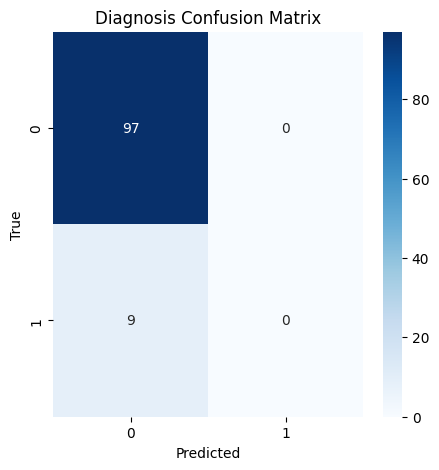

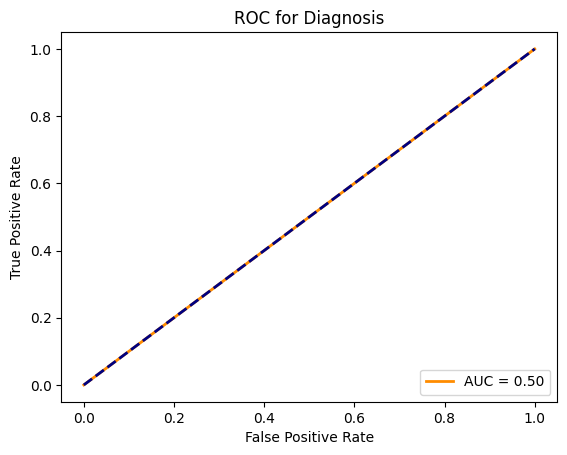

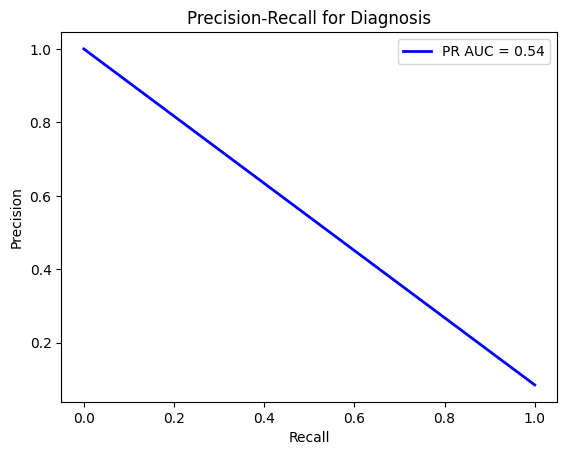


Classification Metrics:
 Accuracy:  0.9811
 Precision: 0.9429
 Recall:    1.0000
 F1 Score:  0.9706


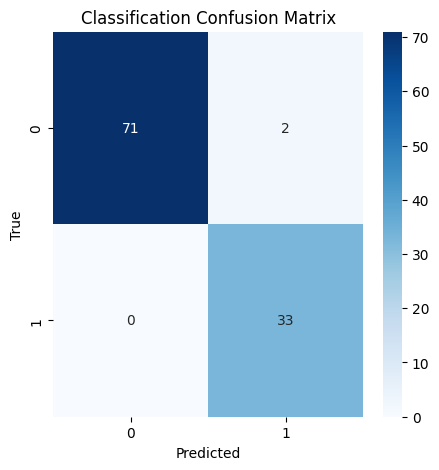

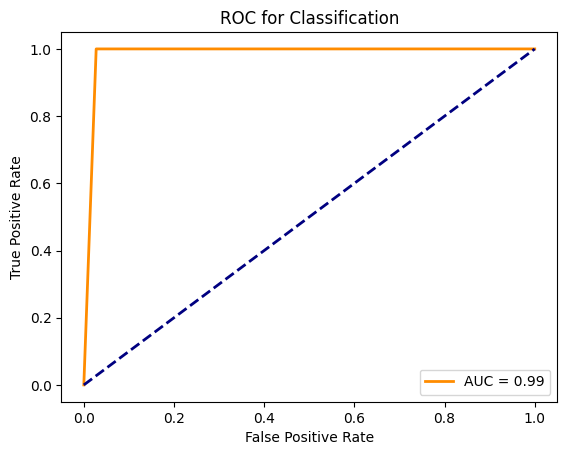

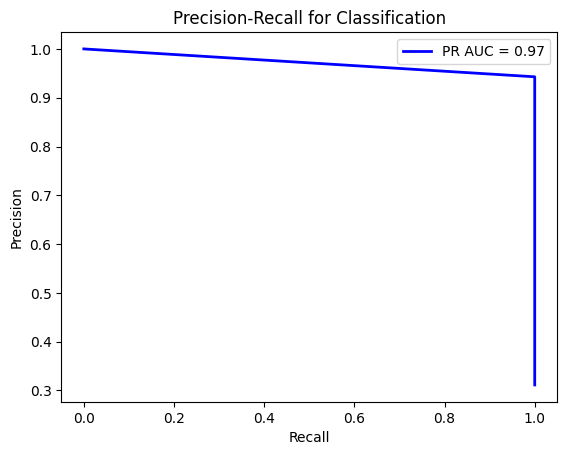


Diagnosis Classification Report:
              precision    recall  f1-score   support

         Neg       0.92      1.00      0.96        97
         Pos       0.00      0.00      0.00         9

    accuracy                           0.92       106
   macro avg       0.46      0.50      0.48       106
weighted avg       0.84      0.92      0.87       106

ASD Classification Report:
              precision    recall  f1-score   support

         Neg       1.00      0.97      0.99        73
         Pos       0.94      1.00      0.97        33

    accuracy                           0.98       106
   macro avg       0.97      0.99      0.98       106
weighted avg       0.98      0.98      0.98       106



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [63]:
print("Evaluating Transformer model...")
transformer_metrics = evaluate_transformer()

In [64]:
print("\nEvaluating Baseline models...")
evaluations_baselines = evaluate_baselines()
pd.DataFrame(evaluations_baselines + transformer_metrics)


Evaluating Baseline models...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,model_name,diagnosis_accuracy,diagnosis_precision,diagnosis_recall,diagnosis_f1,class_accuracy,class_precision,class_recall,class_f1
0,Svm,0.754717,0.185185,0.555556,0.277778,0.943396,1.000000,0.818182,0.900000
1,Decision Tree,0.735849,0.212121,0.777778,0.333333,1.000000,1.000000,1.000000,1.000000
2,Random Forest,0.735849,0.212121,0.777778,0.333333,1.000000,1.000000,1.000000,1.000000
3,Logistic Regression,0.735849,0.212121,0.777778,0.333333,1.000000,1.000000,1.000000,1.000000
4,Knn,0.735849,0.172414,0.555556,0.263158,0.924528,0.931034,0.818182,0.870968
5,Naive Bayes,0.849057,0.111111,0.111111,0.111111,0.773585,1.000000,0.272727,0.428571
6,Mlp,0.792453,0.240000,0.666667,0.352941,0.924528,1.000000,0.757576,0.862069
7,Xgboost,0.735849,0.212121,0.777778,0.333333,1.000000,1.000000,1.000000,1.000000
8,Lightgbm,0.735849,0.212121,0.777778,0.333333,1.000000,1.000000,1.000000,1.000000
9,Transformer,0.915094,0.000000,0.000000,0.000000,0.981132,0.942857,1.000000,0.970588
